# 초기모델

In [ ]:
# BasicBlock 정의
def BasicBlock(inputs, filters, stride=1):
    shortcut = inputs

    x = Conv2D(filters, (3, 3), strides=stride, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, (3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    if stride != 1:
        shortcut = Conv2D(filters, (1, 1), strides=stride, padding='same')(inputs)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

# ResNet 정의
def ResNet18():
    inputs = Input(shape=(32, 32, 3))

    x = Conv2D(64, (3, 3), strides=1, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = BasicBlock(x, 64)
    x = BasicBlock(x, 64)
    x = BasicBlock(x, 128, stride=2)
    x = BasicBlock(x, 128)
    x = BasicBlock(x, 256, stride=2)
    x = BasicBlock(x, 256)
    x = BasicBlock(x, 512, stride=2)
    x = BasicBlock(x, 512)

    x = GlobalAveragePooling2D()(x)
    outputs = Dense(10, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

### 초기에는 데이터증강을 시도하지 않았다.

313/313 [==============================] - 4s 12ms/step - loss: 0.8859 - accuracy: 0.8177
Test loss: 0.8858659863471985
Test accuracy: 0.8177000284194946

### test 데이터의 정확도가 81%정도가 나왔다. 더 좋은 모델을 만들기 위해 데이터 증강을 시도해보았다.

# 1번째 데이터 증강

In [ ]:
def augment(image, label):
    image = tf.image.random_flip_left_right(image) #이미지를 랜덤하게 좌우로 반전
    angle = tf.random.uniform([], -0.2, 0.2)  # 랜덤 각도 생성
    image = tfa.image.rotate(image, angle) # 이미지를 생성한 랜덤한 각도로 회전
    image = tf.image.random_brightness(image, max_delta=0.2)  # 랜덤 밝기 조절
    image = tf.image.random_contrast(image, lower=0.5, upper=1.5)  # 랜덤 대비 조절
    return image, label

def prepare_for_training(ds, shuffle_buffer_size=1000, BATCH_SIZE=32, AUTOTUNE=tf.data.AUTOTUNE):
    ds = ds.map(augment, num_parallel_calls=2)
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(32)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds


(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# 데이터 파이프라인 준비
train_ds = prepare_for_training(train_ds)

데이터 양이 부족하여 정확도가 오르지 않는다고 생각하여 데이터 증강을 진행했다.
첫 증강데이터는 기본적인 증강기법만 사용했다.
초기 모델보다는 정확도가 오를 것이라고 생각했다.

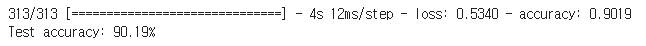

### 초기 모델보다 정확도가 10% 높아졌다. 정확도를 더 높이기 위해 다른 증강기법을 추가해보자

# 2번째 데이터 증강

In [ ]:
def augment(image, label):
    image = tf.image.random_flip_left_right(image)# 무작위 좌우 뒤집기
    image = tf.image.random_flip_up_down(image) #무작위 상하 뒤집기
    angle = tf.random.uniform([], -0.2, 0.2)  # 랜덤 각도 생성
    image = tfa.image.rotate(image, angle) #위에 설정된 랜덤각도로 회전
    image = tf.image.random_contrast(image, lower=0.5, upper=1.5)  # 랜덤 대비 조절
    return image, label

def prepare_for_training(ds, shuffle_buffer_size=1000, BATCH_SIZE=32, AUTOTUNE=tf.data.AUTOTUNE):
    ds = ds.map(augment, num_parallel_calls=2) 
    ds = ds.shuffle(buffer_size=shuffle_buffer_size) 
    ds = ds.repeat() 
    ds = ds.batch(32) 
    ds = ds.prefetch(buffer_size=AUTOTUNE) 
    return ds


(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# 데이터 파이프라인 준비
train_ds = prepare_for_training(train_ds)

### 밝기조절을 빼고 상하 반전을 추가해보았다.

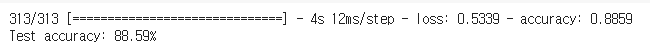

### 1번째 증강 데이터 보다 2% 정도 떨어진 걸 확인할 수 있다. 유의미한 결과를 만들지 않았기 때문에 더 많은 기법을 추가해보려 한다.


# 3번째 데이터 증강

In [ ]:
def augment(image, label):
    image = tf.image.random_flip_left_right(image) #이미지를 랜덤하게 좌우로 반전
    
    image = tf.image.random_flip_up_down(image) #이미지를 랜덤하게 상하로 반전
    
    angle = tf.random.uniform([], -0.2, 0.2) #랜덤한 각도를 생성
    image = tfa.image.rotate(image, angle) #이미지를 생성한 랜덤한 각도로 회전
    
    image = tf.image.random_contrast(image, lower=0.5, upper=1.5) #이미지의 대비를 랜덤하게 조절
    
    image = tf.image.random_brightness(image, max_delta=0.1) #이미지의 밝기를 랜덤하게 조절
    
    image = tf.image.random_hue(image, max_delta=0.05) #이미지의 색조를 랜덤하게 조절

    image = tf.image.random_saturation(image, lower=0.5, upper=1.5) #)이미지의 채도를 랜덤하게 조절
    
    return image, label

def prepare_for_training(ds, shuffle_buffer_size=1000, BATCH_SIZE=32, AUTOTUNE=tf.data.AUTOTUNE):
    ds = ds.map(augment, num_parallel_calls=2) 
    ds = ds.shuffle(buffer_size=shuffle_buffer_size) 
    ds = ds.repeat() 
    ds = ds.batch(32) 
    ds = ds.prefetch(buffer_size=AUTOTUNE) 
    return ds


(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# 데이터 파이프라인 준비
train_ds = prepare_for_training(train_ds)

### 2번째 증강 데이터에 밝기와 색조 채도를 랜덤으로 조절하게 해보았다. 다양한 데이터가 생기기 때문에 정확도가 오를 것으로 생각했다.

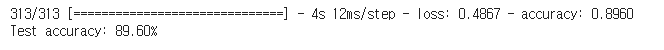

### 1번째 증강 데이터와 비슷하지만 조금 떨어지는 것을 확인할 수 있다. 증강기법이 많아진다고 해서 정확도가 무조건 적으로 오르지는 않았다.

# 4번째 데이터 증강

In [ ]:
def augment(image, label):
    image = tf.image.random_flip_left_right(image) #이미지를 랜덤하게 좌우로 반전
    
    image = tf.image.random_flip_up_down(image) #이미지를 랜덤하게 상하로 반전

    angle = tf.random.uniform([], -0.2, 0.2) #랜덤한 각도를 생성
    image = tfa.image.rotate(image, angle)# 이미지를 생성한 랜덤한 각도로 회전

    image = tf.image.random_contrast(image, lower=0.5, upper=1.5)#이미지의 대비를 랜덤하게 조절

    image = tf.image.random_brightness(image, max_delta=0.1) #이미지의 밝기를 랜덤하게 조절

    image = tf.image.random_hue(image, max_delta=0.05) #이미지의 색조를 랜덤하게 조절
 
    image = tf.image.random_saturation(image, lower=0.5, upper=1.5) #이미지의 채도를 랜덤하게 조절

    image = tf.image.random_jpeg_quality(image, min_jpeg_quality=80, max_jpeg_quality=100) #이미지의 JPEG 압축 품질을 랜덤하게 조절
    
    return image, label


def prepare_for_training(ds, shuffle_buffer_size=1000, BATCH_SIZE=32, AUTOTUNE=tf.data.AUTOTUNE):
    ds = ds.map(augment, num_parallel_calls=2) 
    ds = ds.shuffle(buffer_size=shuffle_buffer_size) 
    ds = ds.repeat() 
    ds = ds.batch(32) 
    ds = ds.prefetch(buffer_size=AUTOTUNE) 
    return ds


(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# 데이터 파이프라인 준비
train_ds = prepare_for_training(train_ds)

### 3번째 증강 데이터에 이미지의 압축품질을 랜덤하게 조절하는 증강기법을 사용해 봤다. 품질을 조절하는 거라 train 정확도는 떨어지지만 일반화가 잘 되어 평가 정확도가 오를 것이란 발칙한 상상을 해보았다. 

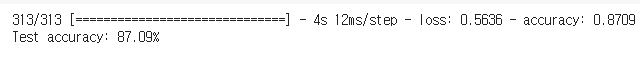

### 하지만 1,2,3번쨰 증강 데이터 보다 결과가 나아지지 않고 오히려 떨어지게 되었다.

# 느낀점

매개 변수 선택 어려움이 너무 어려웠다. 그리고 증강기법의 개수 보다는 적당하게 버무리는 것이 좋다는 걸 깨달았다.